In [1]:
from matplotlib import pyplot as plt
import jax.numpy as np
from jax.config import config
config.update("jax_enable_x64", True)
import numpy as onp
from scipy.linalg import expm
from jax import jit, grad, value_and_grad, vmap
#from time import time
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators.base_operator import BaseOperator
from qiskit.providers.aer.pulse_new.de.DE_Problems import BMDE_Problem
from qiskit.providers.aer.pulse_new.de.DE_Solvers import BMDE_Solver
from qiskit.providers.aer.pulse_new.de.DE_Options import DE_Options
from qiskit.providers.aer.pulse_new.models.signals import VectorSignal, Constant, Signal
from qiskit.providers.aer.pulse_new.models.operator_models import OperatorModel

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 1. Check that basic model set up works

Changes I had to make to get this to work:
- Changed all `numpy` imports to `jax.numpy` in all files
- Changed one `if` statement due to a minor change in `jax` with the way arrays are compared
- Re-added an import of standard `numpy` in one file, to convert `jax` arrays to `numpy` arrays when used to instantiate an `Operator` (`jax` arrays are not accepted)

In [2]:
w = 5.
r = 0.02

signals = [Constant(1.), Signal(1., w)]
operators = [-1j * 2 * np.pi * w * Z / 2, -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(signals=signals, operators=operators)

/opt/anaconda3/envs/devEnv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
generator.evaluate(1.)

DeviceArray([[0.-15.70796327j, 0. -0.06283185j],
             [0. -0.06283185j, 0.+15.70796327j]], dtype=complex128)

Expected value:

In [4]:
gen_at_1 = -1j * 2 * np.pi * w * Z / 2 + onp.cos(2 * np.pi * w * 1.) *(-1j * 2 * np.pi * r * X / 2)
print(gen_at_1)

Operator([[0.-15.70796327j, 0. -0.06283185j],
          [0. -0.06283185j, 0.+15.70796327j]],
         input_dims=(2,), output_dims=(2,))


Enter frame and evaluate:

In [5]:
generator.frame = generator.drift

In [6]:
generator.evaluate(1.)

DeviceArray([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
             [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]],            dtype=complex128)

Expected value:

In [7]:
F = (-1j * 2 * np.pi * w * Z / 2).data
expm(-F) @ gen_at_1.data @ expm(F) - F

array([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
       [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]])

# 2. `jit`-ing

First `jit` and measure time of first evaluation

In [8]:
fast_evaluate = jit(lambda t: generator.evaluate(t))

%time fast_evaluate(1.).block_until_ready()

CPU times: user 347 ms, sys: 78.9 ms, total: 426 ms
Wall time: 54.4 ms


DeviceArray([[ 0.00000000e+00+0.j        , -7.69468277e-17-0.06283185j],
             [ 7.69468277e-17-0.06283185j,  0.00000000e+00+0.j        ]],            dtype=complex128)

Now evaluate compare speed of `jit`ed function and non-`jit`ed

In [9]:
t = 1.

%time res1 = generator.evaluate(t).block_until_ready()

%time res2 = fast_evaluate(t).block_until_ready()

print(res1 - res2)

CPU times: user 21 ms, sys: 11.3 ms, total: 32.3 ms
Wall time: 3.97 ms
CPU times: user 3.22 ms, sys: 1.4 ms, total: 4.62 ms
Wall time: 604 µs
[[0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


# 3. Trying jax solver

In [10]:
from jax.experimental.ode import odeint
from scipy.integrate import solve_ivp

In [11]:
regular_rhs = lambda y, t: generator.lmult(t, y)
fast_rhs = jit(regular_rhs)

In [12]:
%time odeint(func=fast_rhs, y0=np.array([1., 0.], dtype=complex), t=np.array([0., 2./r]), atol=1e-8, rtol=1e-8).block_until_ready()

CPU times: user 986 ms, sys: 40.7 ms, total: 1.03 s
Wall time: 902 ms


DeviceArray([[ 1.00000000e+00+0.00000000e+00j,
               0.00000000e+00+0.00000000e+00j],
             [-1.00000012e+00-1.17843091e-11j,
              -5.51258751e-09-3.48955056e-07j]], dtype=complex128)

In [13]:
def full_int(rhs, t_val):
    return odeint(func=rhs, y0=np.array([1., 0.], dtype=complex), t=np.array([0., t_val]))

In [14]:
#jit_int = jit(full_int)

In [15]:
%time full_int(regular_rhs, 0.5 / r).block_until_ready()

CPU times: user 834 ms, sys: 11.6 ms, total: 846 ms
Wall time: 838 ms


DeviceArray([[ 1.00000000e+00+0.00000000e+00j,
               0.00000000e+00+0.00000000e+00j],
             [ 7.07106933e-01+3.53497031e-04j,
              -2.10677721e-08-7.07106597e-01j]], dtype=complex128)

In [16]:
rhs = jit(generator.lmult)
rhs(0.1, np.array([1, 0])) # avoid measuring time of compilation
%time results = solve_ivp(rhs, (0., 1. / r), y0=onp.array([1., 0.], dtype=complex), method='RK45', atol=1e-10, rtol=1e-10)
results.y[:, 1]

CPU times: user 9.03 s, sys: 1.39 s, total: 10.4 s
Wall time: 8.26 s


array([ 9.99999952e-01-2.49337333e-09j, -2.40556854e-05-3.08949712e-04j])

# 4. Does it differentiate

In [17]:
def param_sim(params):
    t = params
    c = 1.
    gen_copy = generator.copy()
    gen_copy.signals = [Constant(1.), Signal(lambda t: c, w)]
    return np.abs(odeint(func=lambda y, t: gen_copy.lmult(t, y), y0=np.array([1., 0.], dtype=complex), t=np.array([0., t]),atol=1e-8, rtol=1e-8)[-1][1])**2

In [18]:
# just time
#time_param_sim = lambda t: param_sim(np.array([1., t], dtype=complex))

In [19]:
grad_test = jit(value_and_grad(param_sim))

In [20]:
%time grad_test(1./r)[1].block_until_ready()

CPU times: user 1.94 s, sys: 29.3 ms, total: 1.97 s
Wall time: 1.95 s


DeviceArray(2.70190449e-08, dtype=float64)

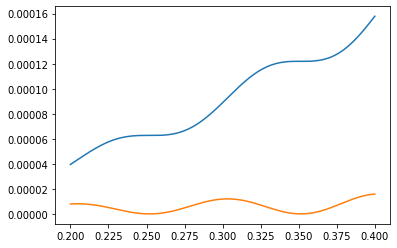

In [21]:
t_vals = np.linspace(0.2, 0.4, 1000)
#vals = vmap(grad_test)(t_vals)
#func_vals = vals[0]
#grad_vals = vals[1]
vals = [grad_test(t) for t in t_vals]
func_vals = np.array([entry[0] for entry in vals])
grad_vals = np.array([entry[1] for entry in vals])
plt.plot(t_vals, func_vals)
plt.plot(t_vals, grad_vals*0.01)

# 5. Trying with solvers

In [22]:
generator = OperatorModel(signals=signals, operators=operators)

de_problem = BMDE_Problem(generator=generator, 
                          y0=np.array([1., 0.], dtype=complex),
                          t0=0.)
options = DE_Options(atol=1e-8, rtol=1e-8)
solver = BMDE_Solver(de_problem, options=options)

In [23]:
%time solver.integrate(1./r)

CPU times: user 872 ms, sys: 11.7 ms, total: 884 ms
Wall time: 874 ms


In [24]:
solver.y @ solver.y.conj().transpose()

DeviceArray(1.00000012+3.32283799e-25j, dtype=complex128)

In [25]:
def full_sim(t):
    gen_copy = generator.copy()
    de_problem = BMDE_Problem(generator=gen_copy, 
                          y0=np.array([1., 0.], dtype=complex),
                          t0=0.,
                          cutoff_freq=2*w)
    options = DE_Options(atol=1e-10, rtol=1e-10)
    solver = BMDE_Solver(de_problem, options=options)
    solver.integrate(t)
    return np.abs(solver.y[1])**2

In [26]:
jit_full_sim = jit(full_sim)
jit_grad_full_sim = jit(value_and_grad(full_sim))

First simulation run with `jit`

In [27]:
%time jit_grad_full_sim(4./r)[0].block_until_ready()

CPU times: user 1.92 s, sys: 29 ms, total: 1.95 s
Wall time: 1.93 s


DeviceArray(2.36073731e-21, dtype=float64)

Cost of second simulation run with `jit`

In [28]:
%time jit_grad_full_sim(9./r)[0].block_until_ready()

CPU times: user 1.36 ms, sys: 825 µs, total: 2.18 ms
Wall time: 855 µs


DeviceArray(1., dtype=float64)

Simulate without `jit`

In [29]:
%time full_sim(1./r)

CPU times: user 889 ms, sys: 14.6 ms, total: 903 ms
Wall time: 890 ms


DeviceArray(1., dtype=float64)

# 6. Optimizing continuous pulses with variable integration length

In [124]:
from qiskit.providers.aer.pulse_new.optimize.optimize import find_pulse_bfgs_parallel
from qiskit.providers.aer.pulse_new.optimize.opt_utils import diffeo

w = 5.
r = 0.02



operators = [-1j * 2 * np.pi * w * Z / 2, 
             -1j * 2 * np.pi * r * X / 2]
generator = OperatorModel(operators=operators)

def gauss(amp, sigma, t0, t):
    return amp * np.exp(-(t - t0)**2 / (2 * sigma)**2)

In [125]:
def signal_generator(amp, sigma, T):
    centered_gauss = lambda t: gauss(amp, sigma, T/2, t)
    
    return [Constant(1.), Signal(centered_gauss, w)]

In [153]:
amp_max = 1.
sigma_max = 30.

def obj(params):
    amp = diffeo(params[0], [-amp_max, amp_max])
    sigma = diffeo(params[1], [0., sigma_max])
    T = 10 * sigma
    gen_copy = generator.copy()
    gen_copy.signals = signal_generator(amp, sigma, T)
    de_problem = BMDE_Problem(generator=gen_copy, 
                      y0=np.array([1., 0.], dtype=complex),
                      t0=0.,
                      cutoff_freq=2*w)
    options = DE_Options(atol=1e-8, rtol=1e-8)
    solver = BMDE_Solver(de_problem, options=options)
    solver.integrate(T)
    return 1 - np.abs(solver.y[1])**2 + 1e-6 * T

In [154]:
opt_shape = (2,)
test = find_pulse_bfgs_parallel(obj, opt_shape, shots=16, n_jobs=8)

Total jobs: 16
Jobs completed: 16
Time taken: 26.017207860946655


In [155]:
best_params = test[0].x
amp = diffeo(best_params[0], [-amp_max, amp_max])
sigma = diffeo(best_params[1], [0, sigma_max])
T = 10 * sigma

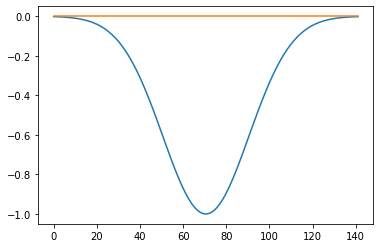

In [156]:
signals = signal_generator(amp, sigma, T)

signals[1].plot_envelope(0, T, 100)

In [157]:
from scipy.integrate import quad

In [158]:
quad(signals[1].envelope, 0., T)

(-49.99845265598881, 1.1914544871538535e-12)

In [164]:
1/r

50.0

In [159]:
obj(test[0].x) - 1e-6 * T

DeviceArray(-1.1125505e-09, dtype=float64)